In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import sqlite3

import os
from dotenv import load_dotenv
from utils.get_or_create_combined_database import get_or_create_combined_database
load_dotenv(verbose=True, override=True)

database_folder = os.getenv("DATABASE_FOLDER")

database_file = get_or_create_combined_database(database_folder)

table_name = "champs_cleaned"

conn = sqlite3.connect(database_file)
query = 'SELECT * FROM champs_cleaned'
data = pd.read_sql_query(query, conn)
conn.close()

# Display the first few rows of the dataframe
data.head()

Found 101 database files in the folder specified by DATABASE_FOLDER
Found combined database D:\league-ezreal-dataset\ml_project\combined2.db


KeyboardInterrupt: 

# Correlation Matrix

In [ ]:

# Group data by compound_key
grouped_data = data.groupby('compound_key')

# Parameters for sliding windows
H = 5  # Window size (number of steps)
step_size = 20  # Step size (time steps apart)

columns_to_use = ['pos_x', 'pos_z', 'hp', 'max_hp', 'max_mana',
                  'armor', 'ad', 'game_id']  # Columns to create sliding windows for


def create_sliding_windows(group, columns, window_size, step_size):
    data_windows = []
    for i in range(window_size * step_size, len(group), step_size):
        window = group[columns].iloc[i-window_size *
                                     step_size:i:step_size].reset_index(drop=True)
        data_windows.append(window.values.flatten())
    columns_expanded = [f'{col}_{j}' for j in range(
        1, window_size+1) for col in columns]
    return pd.DataFrame(data_windows, columns=columns_expanded)


# Create sliding windows for each group
windows = [create_sliding_windows(
    group, columns_to_use, H, step_size) for name, group in grouped_data]

# Combine the windows into a single DataFrame
sliding_windows_data = pd.concat(windows, ignore_index=True)

# Function to reshape the sliding windows data


def reshape_sliding_windows(sliding_windows_data, columns, window_size):
    reshaped_data = {}
    for col in columns:
        for lag in range(window_size):
            reshaped_data[f'{col}_lag_{lag+1}'] = sliding_windows_data[f'{col}_{lag+1}']
    return pd.DataFrame(reshaped_data)


# Reshape the sliding windows data
reshaped_data = reshape_sliding_windows(
    sliding_windows_data, columns_to_use, H)

# Compute the correlation matrix
correlation_matrix = reshaped_data.corr()

# Save the heatmap as an image file
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Temporal Correlation Heatmap')
plt.show()

NameError: name 'data' is not defined

# Mutual Information and Feature Importance

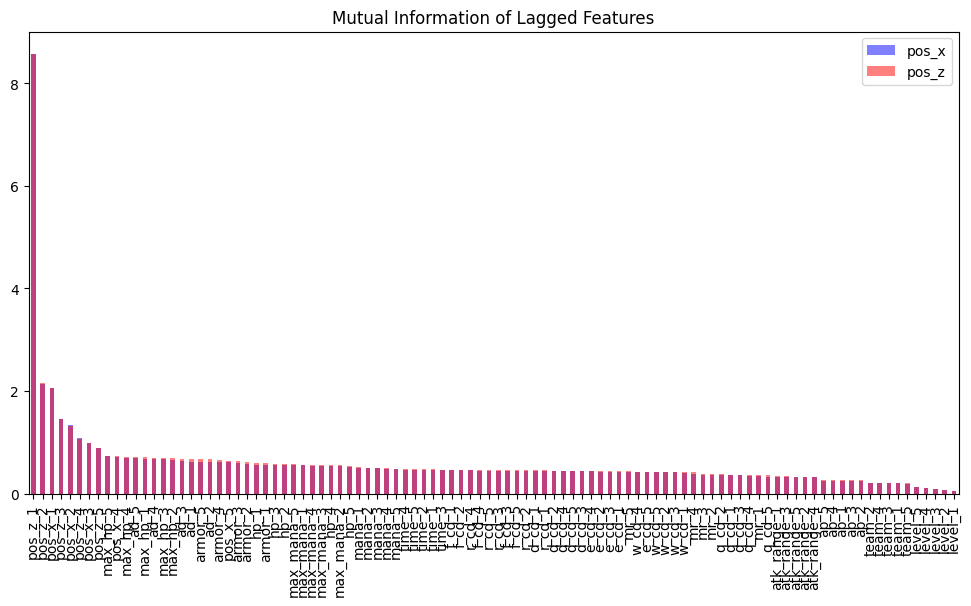

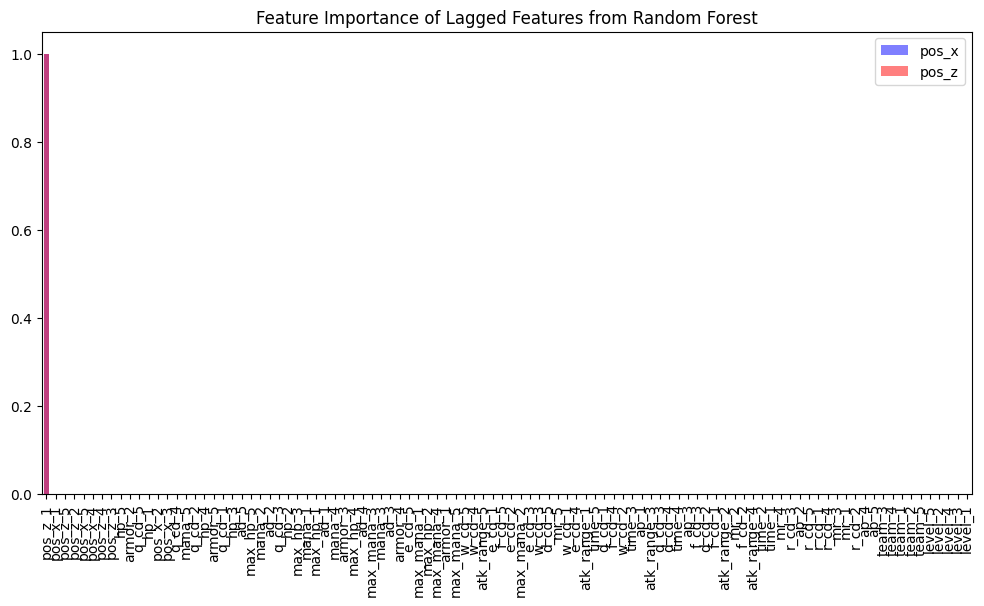

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

# Prepare data for mutual information and feature importance
lagged_features = [
    f'{col}_{lag+1}' for col in columns_to_use for lag in range(H)]
target_columns = ['pos_x', 'pos_z']

X = sliding_windows_data[lagged_features]
y_pos_x = sliding_windows_data["pos_x_1"]
y_pos_z = sliding_windows_data["pos_z_1"]

# Mutual Information for pos_x
mi_pos_x = mutual_info_regression(X, y_pos_x)
mi_pos_x_series = pd.Series(mi_pos_x, index=lagged_features)

# Mutual Information for pos_z
mi_pos_z = mutual_info_regression(X, y_pos_z)
mi_pos_z_series = pd.Series(mi_pos_z, index=lagged_features)

# Plot Mutual Information
plt.figure(figsize=(12, 6))
mi_pos_x_series.sort_values(ascending=False).plot.bar(
    color='blue', alpha=0.5, label=target_columns[0])
mi_pos_z_series.sort_values(ascending=False).plot.bar(
    color='red', alpha=0.5, label=target_columns[1])
plt.title('Mutual Information of Lagged Features')
plt.legend()
plt.show()

# Feature importance for normalized_pos_x
rf_pos_x = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pos_x.fit(X, y_pos_x)
importances_pos_x = rf_pos_x.feature_importances_
importance_pos_x_series = pd.Series(importances_pos_x, index=lagged_features)

# Feature importance for normalized_pos_z
rf_pos_z = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pos_z.fit(X, y_pos_z)
importances_pos_z = rf_pos_z.feature_importances_
importance_pos_z_series = pd.Series(importances_pos_z, index=lagged_features)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
importance_pos_x_series.sort_values(ascending=False).plot.bar(
    color='blue', alpha=0.5, label=target_columns[0])
importance_pos_z_series.sort_values(ascending=False).plot.bar(
    color='red', alpha=0.5, label=target_columns[1])
plt.title('Feature Importance of Lagged Features from Random Forest')
plt.legend()
plt.show()

In [ ]:
# Select important features based on mutual information and feature importance
correlation_threshold = 0.6
important_features = mi_pos_x_series[mi_pos_x_series >
                                     correlation_threshold].index.tolist()

# Create a dataframe with important features
selected_data = sliding_windows_data[important_features]
print("Selected features:")
print(important_features)
print(selected_data.head())

Selected features:
['max_hp_1', 'max_hp_2', 'max_hp_3', 'max_hp_4', 'max_hp_5', 'armor_4', 'armor_5', 'ad_1', 'ad_2', 'ad_3', 'ad_4', 'ad_5', 'pos_x_1', 'pos_x_2', 'pos_x_3', 'pos_x_4', 'pos_x_5', 'pos_z_1', 'pos_z_2', 'pos_z_3', 'pos_z_4', 'pos_z_5']
   max_hp_1  max_hp_2  max_hp_3  max_hp_4  max_hp_5  armor_4  armor_5  ad_1  \
0     655.0     655.0     655.0     655.0     655.0     44.0     44.0  58.0   
1     655.0     655.0     655.0     655.0     655.0     44.0     44.0  58.0   
2     655.0     655.0     655.0     655.0     655.0     44.0     44.0  58.0   
3     655.0     655.0     655.0     655.0     655.0     44.0     44.0  58.0   
4     655.0     655.0     655.0     655.0     655.0     44.0     44.0  58.0   

   ad_2  ad_3  ...    pos_x_1    pos_x_2    pos_x_3    pos_x_4    pos_x_5  \
0  58.0  58.0  ...   664.0000   664.0000   664.0000   664.0000  2344.5452   
1  58.0  58.0  ...   664.0000   664.0000   664.0000  2344.5452  4362.9473   
2  58.0  58.0  ...   664.0000   664.0000  